In [21]:
using Flux, CuArrays
using Flux: onehot, onehotbatch, crossentropy, reset!, throttle, batch, batchseq

In [22]:
corpora = Dict{Symbol,Vector{String}}()

for file in readdir("corpus")
  lang = Symbol(match(r"(.*)\.txt", file).captures[1])
  corpus = split(String(read("corpus/$file")), ".")
  corpus = strip.(normalize_string.(corpus, casefold=true, stripmark=true))
  corpus = filter(!isempty, corpus)
  corpora[lang] = corpus
end

corpora

Dict{Symbol,Array{String,1}} with 5 entries:
  :en => String["wikipedia (/ˌwɪkɪˈpiːdiə/ ( listen), /ˌwɪkiˈpiːdiə/ ( listen)w…
  :it => String["wikipedia (pronuncia: vedi sotto) e un'enciclopediaonline a co…
  :fr => String["wikipediaecouter est un projet d'encyclopedie universelle, mul…
  :es => String["wikipedia es una enciclopedialibre,[nota 2]\u200bpoliglota y e…
  :da => String["wikipedia er en encyklopædi med abent indhold, skrevet i samar…

In [23]:
langs = collect(keys(corpora))
alphabet = ['a':'z'; '0':'9'; ' '; '\n'; '_'; '\0'];

In [24]:
# See which chars will be represented as "unknown"
filter(x -> x ∉ alphabet, unique(join(vcat(values(corpora)...))))

149-element Array{Char,1}:
 '('
 '/'
 'ˌ'
 'ɪ'
 'ˈ'
 'ː'
 'ə'
 ' '
 ')'
 ','
 '-'
 '['
 ']'
 ⋮  
 'ব'
 'ল'
 'দ'
 'শ'
 'চ'
 'ট'
 'ম'
 'ঢ'
 'ক'
 'খ'
 'হ'
 'স'

In [25]:
dataset = [(onehotbatch(s, alphabet, '_').data, onehot(l, langs))
           for l in langs for s in corpora[l]]
dataset = sort(dataset, by = x -> length(x[1]))
dataset = [(batchseq(map(x->x[1],dataset[i]), onehot('\0', alphabet)), batch(map(x->x[2], dataset[i])))
           for i in Iterators.partition(1:length(dataset), 50)] |> shuffle
train, test = dataset[1:end-5], dataset[end-5+1:end];

In [26]:
summary(train)

"162-element Array{Tuple{Array{Flux.OneHotMatrix{Array{Flux.OneHotVector,1}},1},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}},1}"

In [27]:
summary(test)

"5-element Array{Tuple{Array{Flux.OneHotMatrix{Array{Flux.OneHotVector,1}},1},Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}},1}"

In [28]:
N = 15

scanner = Chain(Dense(length(alphabet), N, σ), LSTM(N, N))
encoder = Dense(N, length(langs))

function model(x)
    state = gpu(scanner.(collect.(x))[end])
    reset!(scanner)
    softmax(encoder(state))
end

loss(x, y) = crossentropy(model(x), collect(y))

loss (generic function with 1 method)

In [29]:
testloss() = mean(loss(t...) for t in test)
opt = ADAM(params(scanner, encoder))
evalcb = () -> @show testloss()

(::#53) (generic function with 1 method)

In [30]:
@time for i = 1:10 Flux.train!(loss, train, opt, cb = throttle(evalcb, 10)) end

testloss() = 1.7944761730312382 (tracked)
testloss() = 1.508606485602852 (tracked)
testloss() = 1.4672229002586121 (tracked)


LoadError: [91mInterruptException:[39m

In [ ]:
# open(io -> serialize(io, (langs, alphabet, scanner, encoder)), "model-1.03.jls", "w")

In [31]:
(langs, alphabet, scanner, encoder) = open(deserialize, "model-1.03.jls")

(Symbol[:en, :it, :fr, :es, :da], ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'  …  '4', '5', '6', '7', '8', '9', ' ', '\n', '_', '\0'], Chain(Dense(40, 15, NNlib.σ), Recur(LSTMCell(15, 15))), Dense(15, 5))

In [32]:
using Interact, Plots

In [33]:
predict(s) =
    isempty(s) ?
        softmax(ones(length(langs))) :
        model(onehotbatch(normalize_string(s, casefold=true, stripmark=true), alphabet, '_').data).data

predict (generic function with 1 method)

Interact.Textbox{AbstractString}(21: "input-6" = text goes here AbstractString , "s", nothing, "text goes here")

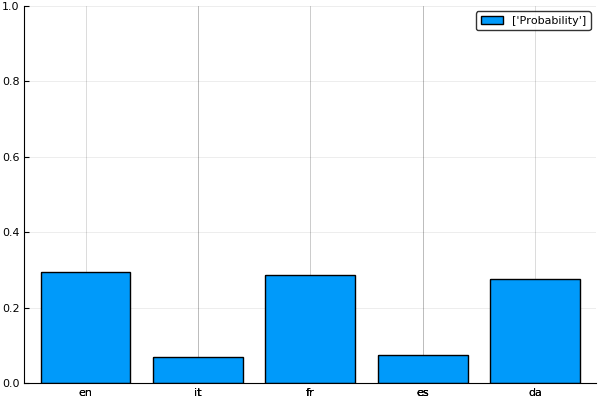

In [34]:
@manipulate for s = "text goes here"
    bar(String.(langs), predict(s),
        label=["Probability"], ylims=(0,1))
end